# Import, save and export data


In this notebook, we look at import functions and how to assign data to the grid. 

---

We import the class (as explained in turorial 1): 

In [27]:
import sys
sys.path.append('..')

from agrid.grid import Grid
from agrid.acc import download

Now we make two grid objects, one of the Antarctic continent in  [EPSG:3031. WGS 84 / Antarctic Polar Stereographic projection](https://epsg.io/3031) and also a global model, using [WGS84](https://epsg.io/4326). Resolution is defined in the unit of the projection, meters for stereographic projection, and degrees for the global grid. The coordinates in the xarray dataset are stored as dask arrays, they are not loaded until they are needed. When processed, they are loaded as smaller chunks, 1/10 of the axes large. 

In [28]:
#Continental
km = 1000

ant = Grid(crs=3031, res = [1*km, 1*km], 
           left = -3100*km, up=3100*km, right = 3100*km, down = -3100*km)

print(ant.ds)

#Global
world = Grid(crs=4326, res = [1, 1], left = -180, up=90, right = 180, down = -90)

print(world.ds)

<xarray.Dataset>
Dimensions:  (RGB: 3, X: 6200, X_edge: 6201, Y: 6200, Y_edge: 6201, Z: 5, Z_edge: 6)
Coordinates:
  * X        (X) float32 -3100000.0 -3098999.8 ... 3098999.8 3100000.0
  * Y        (Y) float32 -3100000.0 -3098999.8 ... 3098999.8 3100000.0
  * Z        (Z) float32 0.0 8000.0 16000.0 40000.0 350000.0
  * X_edge   (X_edge) float32 -3100500.0 -3099499.8 ... 3099499.8 3100500.0
  * Y_edge   (Y_edge) float32 -3100500.0 -3099499.8 ... 3099499.8 3100500.0
  * Z_edge   (Z_edge) float64 -4e+03 4e+03 1.2e+04 2.8e+04 1.95e+05 5.05e+05
  * RGB      (RGB) <U1 'R' 'G' 'B'
    XV       (Y, X) float32 dask.array<shape=(6200, 6200), chunksize=(620, 620)>
    YV       (Y, X) float32 dask.array<shape=(6200, 6200), chunksize=(620, 620)>
    lat      (Y, X) float32 dask.array<shape=(6200, 6200), chunksize=(620, 620)>
    lon      (Y, X) float32 dask.array<shape=(6200, 6200), chunksize=(620, 620)>
Data variables:
    *empty*
<xarray.Dataset>
Dimensions:  (RGB: 3, X: 360, X_edge: 361, Y: 180

We download a raster, in this case the global 1:50m Bathymetry. It is about 100Mb, so it might take a while.  

In [5]:
download('''https://naciscdn.org/naturalearth/50m/raster/HYP_50M_SR_W.zip''',
         '../../../data/ne/HYP_50M_SR_W.zip')


File ../../../data/ne/HYP_50M_SR_W.zip already exists.


['HYP_50M_SR_W/',
 'HYP_50M_SR_W/HYP_50M_SR_W.prj',
 'HYP_50M_SR_W/HYP_50M_SR_W.README.html',
 'HYP_50M_SR_W/HYP_50M_SR_W.tfw',
 'HYP_50M_SR_W/HYP_50M_SR_W.tif',
 'HYP_50M_SR_W/HYP_50M_SR_W.VERSION.txt']

We import the raster to the global grid and to the Antarctic grid: 
The raster has three channels, so we assign it to X, Y and RGB coordinates. This might also take some time, as the raster needs to be warped to each grid cell. We can speed up a bit by subsampling the raster before warp. 

../agrid/grid.py:1110: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  epsg=basemap_epsg, **kwargs)


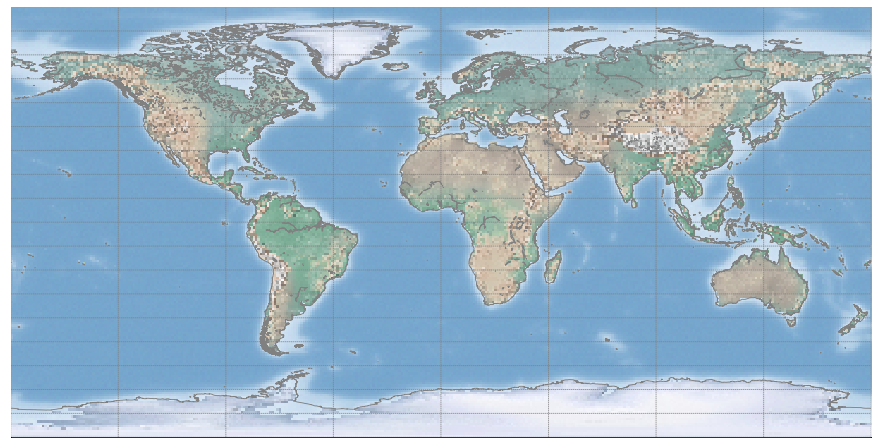

In [6]:
world.ds['RGB_RASTER'] = (('Y', 'X', 'RGB'), 
                world.read_raster('../../data/ne/HYP_50M_SR_W/HYP_50M_SR_W.tif', sub_sampling=5) )
world.map_grid('RGB_RASTER')


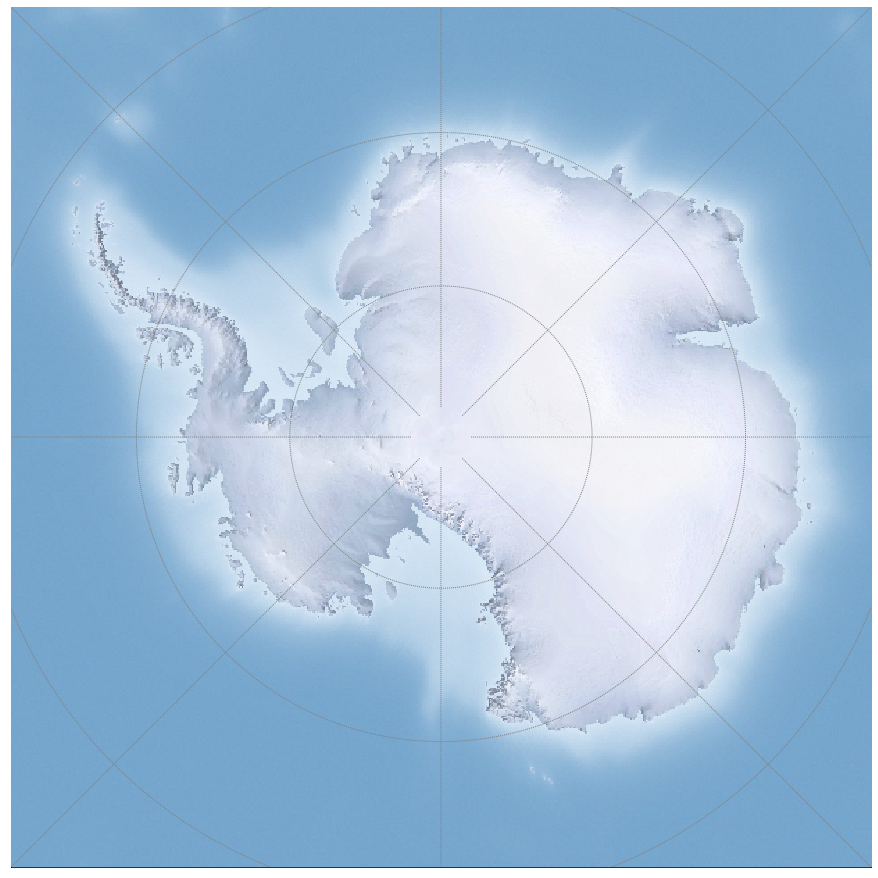

In [7]:
ant.ds['RGB_RASTER'] = (('Y', 'X', 'RGB'), 
                        ant.read_raster('../../data/ne/HYP_50M_SR_W/HYP_50M_SR_W.tif', 
                                                           sub_sampling=3) )

ant.map_grid('RGB_RASTER', draw_coast=False)

The function read_raster returns a numpy array, that is assigned to the dataFrame and liked to coordinates (Y, X, and RGB). As explaned earlier, Y comes before X as arrays are indexed rows-columns. 

sub_sampling subsamples unnecisary large arrays before reprojecting. Source extra adds some extra cells around the margin to ensure that the dateline is correctely rendered. 

Pretty, but the raison d'etre for this code is to work properly with 3D models. We download AN-1S sesimic 3D model of the Antarctic lithosphere. 

In [8]:
download('http://www.seismolab.org/model/antarctica/lithosphere/AN1-S_depth_grd.tar.gz',
         '../../data/an/AN1-S_depth_grd.tar.gz')


File ../../data/an/AN1-S_depth_grd.tar.gz already exists.


['AN1-S_hslice_000.0.grd',
 'AN1-S_hslice_002.5.grd',
 'AN1-S_hslice_005.0.grd',
 'AN1-S_hslice_007.5.grd',
 'AN1-S_hslice_010.0.grd',
 'AN1-S_hslice_012.5.grd',
 'AN1-S_hslice_015.0.grd',
 'AN1-S_hslice_017.5.grd',
 'AN1-S_hslice_020.0.grd',
 'AN1-S_hslice_025.0.grd',
 'AN1-S_hslice_030.0.grd',
 'AN1-S_hslice_035.0.grd',
 'AN1-S_hslice_040.0.grd',
 'AN1-S_hslice_045.0.grd',
 'AN1-S_hslice_050.0.grd',
 'AN1-S_hslice_055.0.grd',
 'AN1-S_hslice_060.0.grd',
 'AN1-S_hslice_065.0.grd',
 'AN1-S_hslice_070.0.grd',
 'AN1-S_hslice_075.0.grd',
 'AN1-S_hslice_080.0.grd',
 'AN1-S_hslice_085.0.grd',
 'AN1-S_hslice_090.0.grd',
 'AN1-S_hslice_095.0.grd',
 'AN1-S_hslice_100.0.grd',
 'AN1-S_hslice_105.0.grd',
 'AN1-S_hslice_110.0.grd',
 'AN1-S_hslice_115.0.grd',
 'AN1-S_hslice_120.0.grd',
 'AN1-S_hslice_125.0.grd',
 'AN1-S_hslice_130.0.grd',
 'AN1-S_hslice_135.0.grd',
 'AN1-S_hslice_140.0.grd',
 'AN1-S_hslice_145.0.grd',
 'AN1-S_hslice_150.0.grd',
 'AN1-S_hslice_155.0.grd',
 'AN1-S_hslice_160.0.grd',
 

We loop through the files and read them 2D, by 2D to the 3D grid $^1$. 

---
1. This is incorperated in the methods for the latest version of agrid `bulk = True`. However, there were some ambigous cases that should be resolved. 

In [9]:
import glob, os
import numpy as np

an_files = sorted(glob.glob('../../data/an/*.grd'))
#print(an_files)
ant.ds.coords['AN_Z'] = [np.float32(d[-9:-4])*km for d in an_files]
str_depths = [str(d[-9:-4]) for d in an_files]

an_array = np.empty((ant.nx, ant.ny, len(an_files)))
an_array[:] = np.nan
for i, a in enumerate(ant.ds.coords['AN_Z'].values):
    print(a//km, end=' ')
    fname = '../../data/an/AN1-S_hslice_%s.grd'%str_depths[i]
    if os.path.isfile(fname):
        an_array[:,:,i] = ant.read_grid(fname, xyz = ('x','y','z') ) 
    
ant.ds['AN_S'] = (('Y', 'X', 'AN_Z'), an_array)

-0.0 2.0 5.0 7.0 10.0 12.0 15.0 17.0 20.0 25.0 30.0 35.0 40.0 45.0 50.0 55.0 60.0 65.0 70.0 75.0 80.0 85.0 90.0 95.0 100.0 105.0 110.0 115.0 120.0 125.0 130.0 135.0 140.0 145.0 150.0 155.0 160.0 165.0 170.0 180.0 190.0 200.0 210.0 220.0 230.0 240.0 250.0 275.0 300.0 325.0 350.0 

../agrid/grid.py:1110: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  epsg=basemap_epsg, **kwargs)


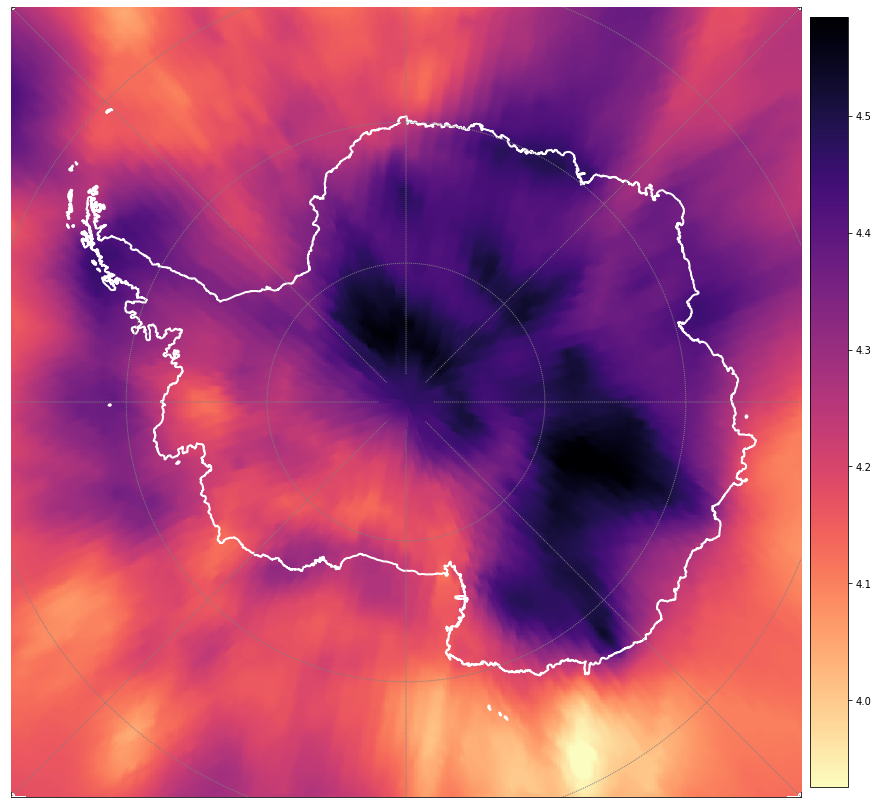

In [10]:
ant.map_grid(ant.ds['AN_S'].sel(AN_Z=150*km), cmap='magma_r', line_w=2, line_c='w', cbar=True)

Say we want to look at a 1D velocity model, e.g. [AK135, Kennett, Engdahl & Buland (1995)](http://rses.anu.edu.au/seismology/ak135/ak135f.html). We get it from IRIS: 

File ../local/AK135F_AVG.csv already exists.


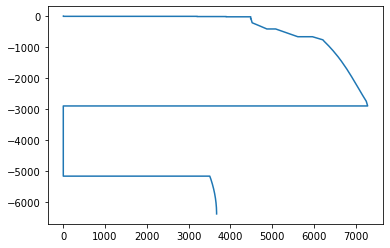

In [11]:
from matplotlib import pyplot as plt

download('http://ds.iris.edu/files/products/emc/data/AK135F/AK135F_AVG.csv',
         '../local/AK135F_AVG.csv')


ak_135_d, _, ak_135_vp, ak_135_vs,_,_  = np.genfromtxt( '../local/AK135F_AVG.csv', delimiter=',', unpack=True)*km #To SI unit

plt.plot(ak_135_vs, -ak_135_d/km)
plt.show()

ant.ds.coords['AK135_Z'] = ak_135_d
ant.ds['AK135_SV'] = (('AK135_Z'), ak_135_vs)

Say we want to compare AN_S model with AK135 at 315km, but the depth value is not defined in AK135. Matplotlib can be used directely on the agrid object. 

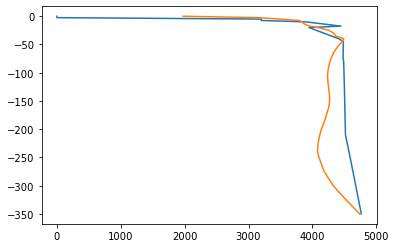

In [12]:
ant.ds['AK135_SV_LITH'] = ( ('AN_Z'), 
                           ant.change_coord(ant.ds['AK135_SV'], ant.ds['AK135_Z'], ant.ds['AN_Z'], axis=-1) )

An = ant.ds['AN_S'].mean(dim=['X', 'Y'])*km

plt.plot(ant.ds['AK135_SV_LITH'], -ant.ds['AN_Z']/km, An, -ant.ds['AN_Z']/km)
plt.show()

We set up a toy example. We would like to use AK135 to calculate the perturbation in AN1-S, but only for West Antarctica. We make a mask from a very loose definition: 

In [13]:
import xarray as xr

ant.ds['WEST_ANTARCTICA'] = xr.DataArray(np.zeros(ant.nn).astype(bool), dims=['Y', 'X']).where(ant.ds.X>-300*km)


We don't worry about the warning. There are probably some crossing vertecies somewhere in the coast line. 

We use ´where´ to only select cells where `ant.ds['WEST_ANTARCTICA']` is `TRUE`. Here, we use index to select depth slice. 

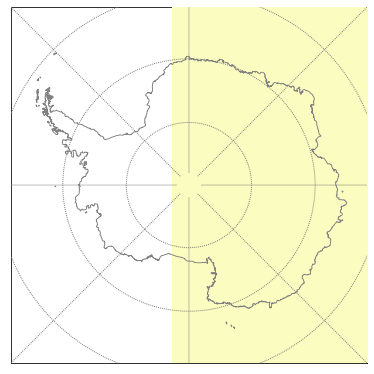

In [14]:
ant.map_grid(ant.ds['WEST_ANTARCTICA'], cmap='magma_r', figsize=(5,5))

We can use this boolean grid to select parts of datasets:

../agrid/grid.py:1110: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  epsg=basemap_epsg, **kwargs)


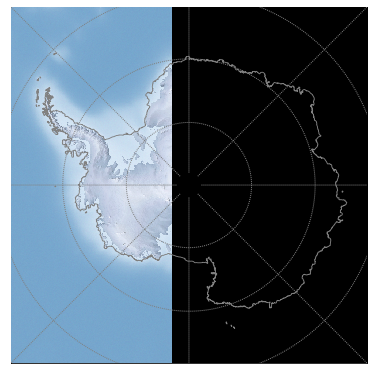

In [15]:
ant.map_grid(ant.ds['RGB_RASTER'].where(ant.ds['WEST_ANTARCTICA']), figsize=(5,5))

In [16]:
ant.ds['WEST_SEL'] = ant.ds['AN_S'].where(ant.ds['WEST_ANTARCTICA'])

We can also import 1-band rasters, eg Bedmap ice sheet thickness (Large files!):

File ../data/Bedmap/bedmap2_tiff.zip already exists.


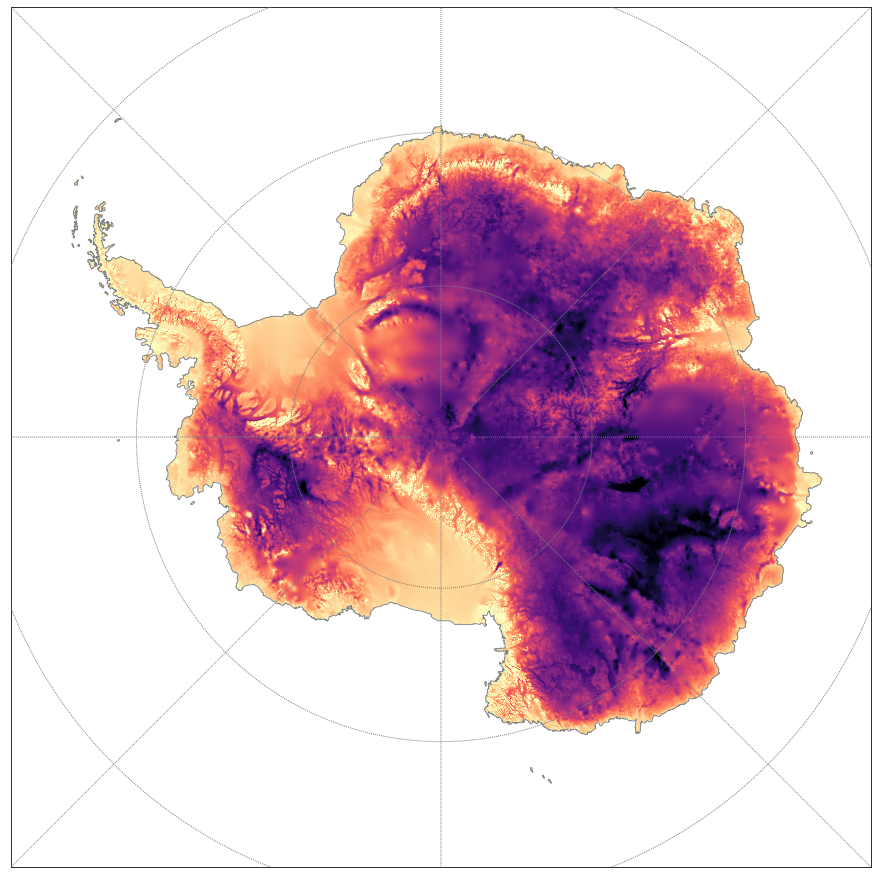

In [25]:
bedmap_data = 'bedmap2_tiff.zip'
bedmap_url = 'https://secure.antarctica.ac.uk/data/bedmap2/'
download(bedmap_url + bedmap_data,
                  '../data/Bedmap/'+ bedmap_data)


ant.ds['ICE'] = (('Y', 'X'), 
                ant.read_raster('../data/bedmap2_tiff/bedmap2_thickness.tif', no_data = 32767.) )


ant.map_grid(ant.ds['ICE'], cmap='magma_r')

We now have populated our grid object with a number of datasets: 

In [18]:
ant.ds

<xarray.Dataset>
Dimensions:          (AK135_Z: 145, AN_Z: 51, RGB: 3, X: 620, X_edge: 621, Y: 620, Y_edge: 621, Z: 5, Z_edge: 6)
Coordinates:
  * Y                (Y) float64 -3.1e+06 -3.09e+06 ... 3.09e+06 3.1e+06
  * X                (X) float64 -3.1e+06 -3.09e+06 ... 3.09e+06 3.1e+06
  * Z                (Z) float32 0.0 8000.0 16000.0 40000.0 350000.0
  * X_edge           (X_edge) float32 -3105000.0 -3094983.8 ... 3105000.0
  * Y_edge           (Y_edge) float32 -3105000.0 -3094983.8 ... 3105000.0
  * Z_edge           (Z_edge) float64 -4e+03 4e+03 1.2e+04 ... 1.95e+05 5.05e+05
  * RGB              (RGB) <U1 'R' 'G' 'B'
    XV               (Y, X) float32 dask.array<shape=(620, 620), chunksize=(62, 62)>
    YV               (Y, X) float32 dask.array<shape=(620, 620), chunksize=(62, 62)>
    lat              (Y, X) float32 dask.array<shape=(620, 620), chunksize=(62, 62)>
    lon              (Y, X) float32 dask.array<shape=(620, 620), chunksize=(62, 62)>
  * AN_Z             (AN_Z) fl

We can save data arrays as netCDF or GMT grids: 

In [19]:
ant.grid_to_grd(ant.ds['RGB'], save_name='rgb.nc')

Save to geotiff: 

In [26]:
#A = ant.grid_to_raster('RGB_RASTER', save_name ='rgb.tif')
B = ant.grid_to_raster('ICE', save_name ='ice.tif')

#print(ant.ds['RGB_RASTER'].shape)
print(ant.ds['ICE'].shape)

Sving
(6200, 6200)


Saving the complete class object using ´pickle´ can also be handy. Be aware of the [risks with pickle](https://intoli.com/blog/dangerous-pickles/), only open files that you trust. 

In [1]:
import pickle
pickle.dump(ant, open( "ant.p", "wb" ))

NameError: name 'ant' is not defined

In [11]:
del(ant)
ant.ds

NameError: name 'ant' is not defined

In [2]:
import pickle
ant = pickle.load( open( "ant.p", "rb" ) )
print(ant.ds)

FileNotFoundError: [Errno 2] No such file or directory: 'ant.p'

Sometimes a json file with the parameters is useful: 

In [ ]:
ant.save_info(file_name='ant.json')

Or the frame in ascii format, for some GIS applications. This is a first example of a suite of export functions used to extract data from the grid. E.g. Red channel from RGB raster: 

In [ ]:
ant.grid_to_ascii(ant.ds['RGB_RASTER'][:,:,1])